In [ ]:
# book code
import pandas as pd

df = pd.read_csv('cwsac_battles.csv', parse_dates=['start_date'], index_col=0)
df.loc[df['battle_name'].str.contains('Cold Harbor')].T

battle,VA062
url,http://www.nps.gov/abpp/battles/va062.htm
battle_name,Cold Harbor
other_names,Second Cold Harbor
state,VA
locations,"Hanover County, VA"
campaign,Grant's Overland Campaign [May-June 1864]
start_date,1864-05-31 00:00:00
end_date,1864-06-12
operation,0
assoc_battles,NaN


In [ ]:
import pickle
import operator

with open('cwsac_battles_locations.pkl', 'rb') as f:
  locations = pickle.load(f)

# first exclude battles not associated with named locations
df = df.loc[df['locations'].notnull()]

# extract first place name associated with battle
df['location_name'] = df['locations'].str.split(';').apply(operator.itemgetter(0))

# add lat and lon to each row
df['lat'] = df['location_name'].apply(lambda name: locations[name]['lat'])
df['lon'] = df['location_name'].apply(lambda name: locations[name]['lon'])

<ipython-input-2-a56af179c974>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['location_name'] = df['locations'].str.split(';').apply(operator.itemgetter(0))
<ipython-input-2-a56af179c974>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat'] = df['location_name'].apply(lambda name: locations[name]['lat'])
<ipython-input-2-a56af179c974>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [ ]:
columns_of_interest = ['battle_name', 'locations', 'start_date', 'casualties', 'lat', 'lon', 'result', 'campaign']
df[columns_of_interest].sort_values('casualties', ascending=False).head(3)

,battle_name,locations,start_date,casualties,lat,lon,result,campaign
battle,,,,,,,,
PA002,Gettysburg,"Adams County, PA",1863-07-01,51000.0,39.873030,-77.217873,Union,Gettysburg Campaign [June-July 1863]
GA004,Chickamauga,"Catoosa County, GA; Walker County, GA",1863-09-18,34624.0,34.904493,-85.135566,Confederate,Chickamauga Campaign [August-September 1863]
VA048,Spotsylvania Court House,"Spotsylvania County, VA",1864-05-08,30000.0,38.184116,-77.655980,Inconclusive,Grant's Overland Campaign [May-June 1864]


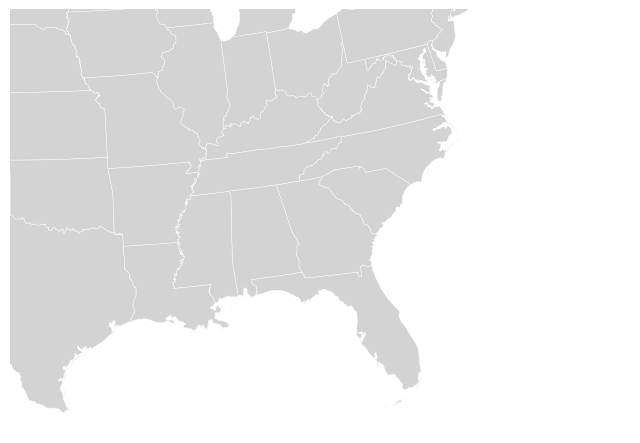

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shapereader
from cartopy.feature import ShapelyFeature

# step 1: define projection. use LCC as the default projection
# center of lower 48 states is around 38, -100
# 32 for first standard latitude and 44 for first standard longitude

projection = ccrs.LambertConformal(
    central_latitude=38,
    central_longitude=-100,
    standard_parallels=(32,44))

# step 2: set up a base figure and attach subfigure with defined projection
fig = plt.figure(figsize=(8,8))
m = fig.add_subplot(1, 1, 1, projection=projection)
m.set_extent([-70, -100, 40, 25], crs=ccrs.PlateCarree())

# step 3 read shapefile and transform into a ShapelyFeature
shape_feature = ShapelyFeature(
    shapereader.Reader('st99_d00.shp').geometries(),
    ccrs.PlateCarree(),
    facecolor='lightgray',
    edgecolor='white'
)
m.add_feature(shape_feature, linewidth=0.3)

# step 4 add aesthetics (no outline box)
m.spines['geo'].set_visible(False)

In [ ]:
def basemap(shapefile, projection, extent=None, nrows=1, ncols=1, figsize=(8, 8)):
    f, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=100,
        subplot_kw=dict(projection=projection, frameon=False))
    axes = [axes] if (nrows + ncols) == 2 else axes.flatten()
    shape_feature = ShapelyFeature(
            shapereader.Reader(shapefile).geometries(),
            ccrs.PlateCarree(), facecolor='lightgray', edgecolor='white')
    for ax in axes:
        ax.set_extent(extent, ccrs.PlateCarree())
        ax.add_feature(shape_feature, linewidth=0.3)
        ax.spines['geo'].set_visible(False)
    return f, (axes[0] if (nrows + ncols) == 2 else axes)

def civil_war_basemap(nrows=1, ncols=1, figsize=(8, 8)):
    projection = ccrs.LambertConformal(
        central_latitude=38, central_longitude=-100,
        standard_parallels=(32, 44))
    extent = -70, -100, 40, 25
    return basemap('st99_d00.shp', projection, extent=extent,
                   nrows=nrows, ncols=ncols, figsize=figsize)

In [ ]:
# Richmond, Virginia has decimal latitude and longitude:
#    37.533333, -77.466667
x, y = m.transData.transform((37.533333, -77.466667))
print(x, y)

100.00766971034632 479.43196589743116


In [ ]:
# Recover the latitude and longitude for Richmond, Virginia
print(m.transData.inverted().transform((x, y)))

[ 37.533333 -77.466667]


In [ ]:
battles_of_interest = ['LA003', 'KY008', 'VA026']
three_battles = df.loc[battles_of_interest]

battle_names = three_battles['battle_name']
battle_years = three_battles['start_date'].dt.year
labels = [f'{name} ({year})' for name, year in zip(battle_names, battle_years)]
print(labels)

['Baton Rouge (1862)', 'Munfordville (1862)', 'Manassas, Second (1862)']


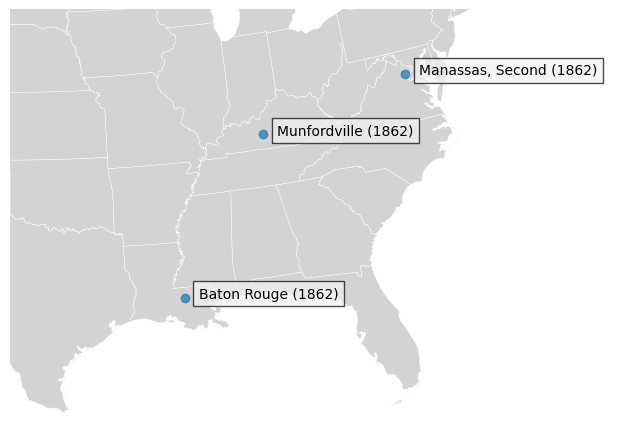

In [ ]:
# draw the map
f, m = civil_war_basemap(figsize=(8, 8))
# add points
m.scatter(three_battles['lon'], three_battles['lat'],
          zorder=2, marker='o', alpha=0.7, transform=ccrs.PlateCarree())
# add labels
for x, y, label in zip(three_battles['lon'], three_battles['lat'], labels):
    # NOTE: the "plt.annotate call" does not have a "transform=" keyword,
    # so for this one we transform the coordinates with a Cartopy call.
    x, y = m.projection.transform_point(x, y, src_crs=ccrs.PlateCarree())
    # position each label to the right of the point
    # give the label a semi-transparent background so it is easier to see
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(10, 0),
                 # xytext is measured in figure points,
                 # 0.353 mm or 1/72 of an inch
                 textcoords='offset points',
                 bbox=dict(fc='#f2f2f2', alpha=0.7))

In [ ]:
three_battles[columns_of_interest]

,battle_name,locations,start_date,casualties,lat,lon,result,campaign
battle,,,,,,,,
LA003,Baton Rouge,"East Baton Rouge Parish, LA",1862-08-05,849.0,30.542141,-91.095604,Union,Operations Against Baton Rouge [July-August 1862]
KY008,Munfordville,"Hart County, KY",1862-09-14,4862.0,37.294492,-85.884709,Confederate,Confederate Heartland Offensive [June-October ...
VA026,"Manassas, Second","Prince William County, VA",1862-08-28,22180.0,38.662376,-77.432476,Confederate,Northern Virginia Campaign [August 1862]


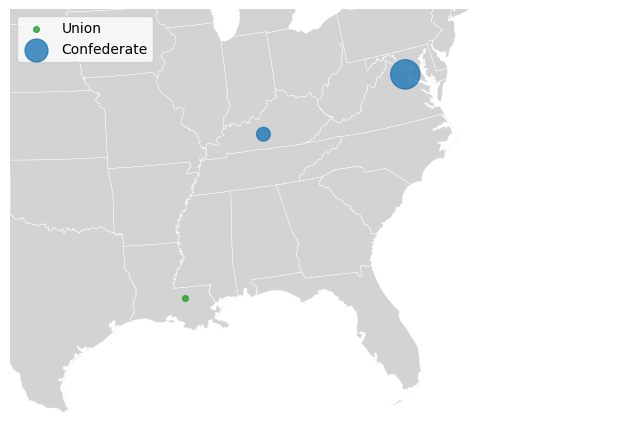

In [ ]:
import itertools
import matplotlib.cm


def result_color(result_type):
    """Helper function: return a qualitative color for each
       party in the war.
    """
    result_types = 'Confederate', 'Inconclusive', 'Union'
    # qualitative color map, suited for categorical data
    color_map = matplotlib.cm.tab10
    return color_map(result_types.index(result_type))


def plot_battles(lat, lon, casualties, results, m=None, figsize=(8, 8)):
    """Draw circles with area proportional to `casualties`
       at `lat`, `lon`.
    """
    if m is None:
        f, m = civil_war_basemap(figsize=figsize)
    else:
        f, m = m
    # make a circle proportional to the casualties
    # divide by a constant, otherwise circles will cover much of the map
    size = casualties / 50
    for result_type, result_group in itertools.groupby(
        zip(lat, lon, size, results), key=operator.itemgetter(3)):
        lat, lon, size, results = zip(*list(result_group))
        color = result_color(result_type)
        m.scatter(lon, lat, s=size, color=color, alpha=0.8,
                  label=result_type, transform=ccrs.PlateCarree(), zorder=2)
    return f, m

lat, lon, casualties, results = (three_battles['lat'], three_battles['lon'],
                                 three_battles['casualties'], three_battles['result'])
plot_battles(lat, lon, casualties, results)
plt.legend(loc='upper left');

In [ ]:
# replace battles with NaN casualties with a plausible estimate
df.loc[df['casualties'].isnull(), 'casualties'] = df['casualties'].quantile(0.20)

# rearrange data to get a sense of the evolution of casualties over the course of the war
df.groupby(df['start_date'].dt.year).size()
df.groupby(df['start_date'].dt.year)['casualties'].sum()
df.groupby(df.start_date.dt.strftime('%Y-%m'))['casualties'].sum().head()

,casualties
start_date,
1861-04,0.0
1861-05,20.0
1861-06,198.0
1861-07,5555.0
1861-08,3388.0


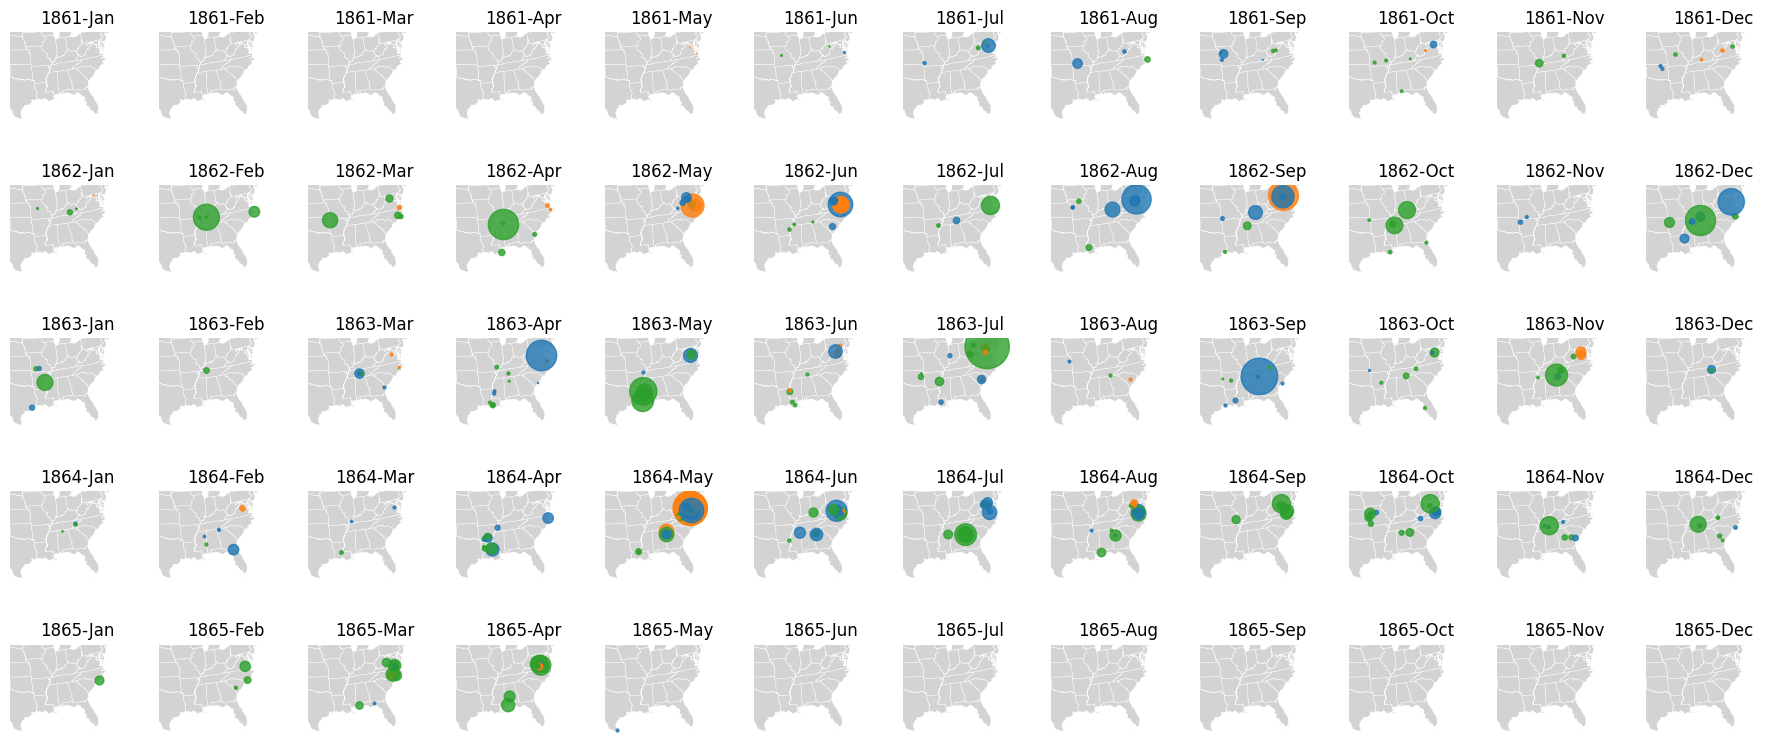

In [ ]:
import calendar
import itertools

f, maps = civil_war_basemap(nrows=5, ncols=12, figsize=(18, 8))

# Predefine an iterable of dates. The war begins in April 1861, and
# the Confederate government dissolves in spring of 1865.
dates = itertools.product(range(1861, 1865 + 1), range(1, 12 + 1))

for (year, month), m in zip(dates, maps):
    battles = df.loc[(df['start_date'].dt.year == year) &
                     (df['start_date'].dt.month == month)]
    lat, lon = battles['lat'].values, battles['lon'].values
    casualties, results = battles['casualties'], battles['result']
    plot_battles(lat, lon, casualties, results, m=(f, m))
    month_abbrev = calendar.month_abbr[month]
    m.set_title(f'{year}-{month_abbrev}')

plt.tight_layout();

# Easy

In [ ]:
# How many battles won each by the Union & Confederates?
df['result'].value_counts()

,count
result,
Union,195
Confederate,122
Inconclusive,65


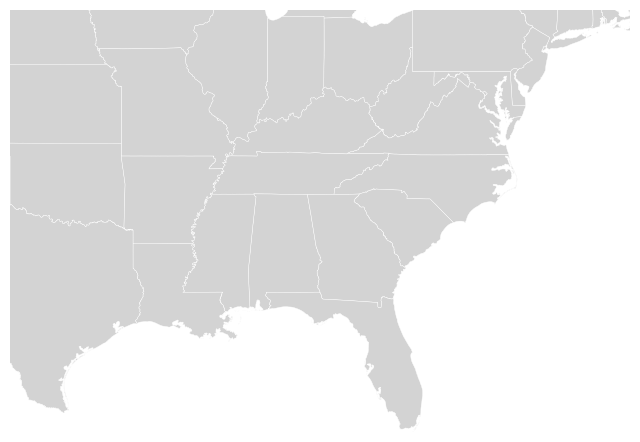

In [ ]:
# step 1: define projection, use Mercator this time

projection = ccrs.Mercator(
    central_longitude=-100,
    min_latitude=25,
    max_latitude=52)

# step 2: set up a base figure and attach subfigure with defined projection
fig = plt.figure(figsize=(8,8))
m = fig.add_subplot(1, 1, 1, projection=projection)
m.set_extent([-70, -100, 42, 25], crs=ccrs.PlateCarree())

# step 3 read shapefile and transform into a ShapelyFeature
shape_feature = ShapelyFeature(
    shapereader.Reader('st99_d00.shp').geometries(),
    ccrs.PlateCarree(),
    facecolor='lightgray',
    edgecolor='white'
)
m.add_feature(shape_feature, linewidth=0.3)

# step 4 add aesthetics (no outline box)
m.spines['geo'].set_visible(False)

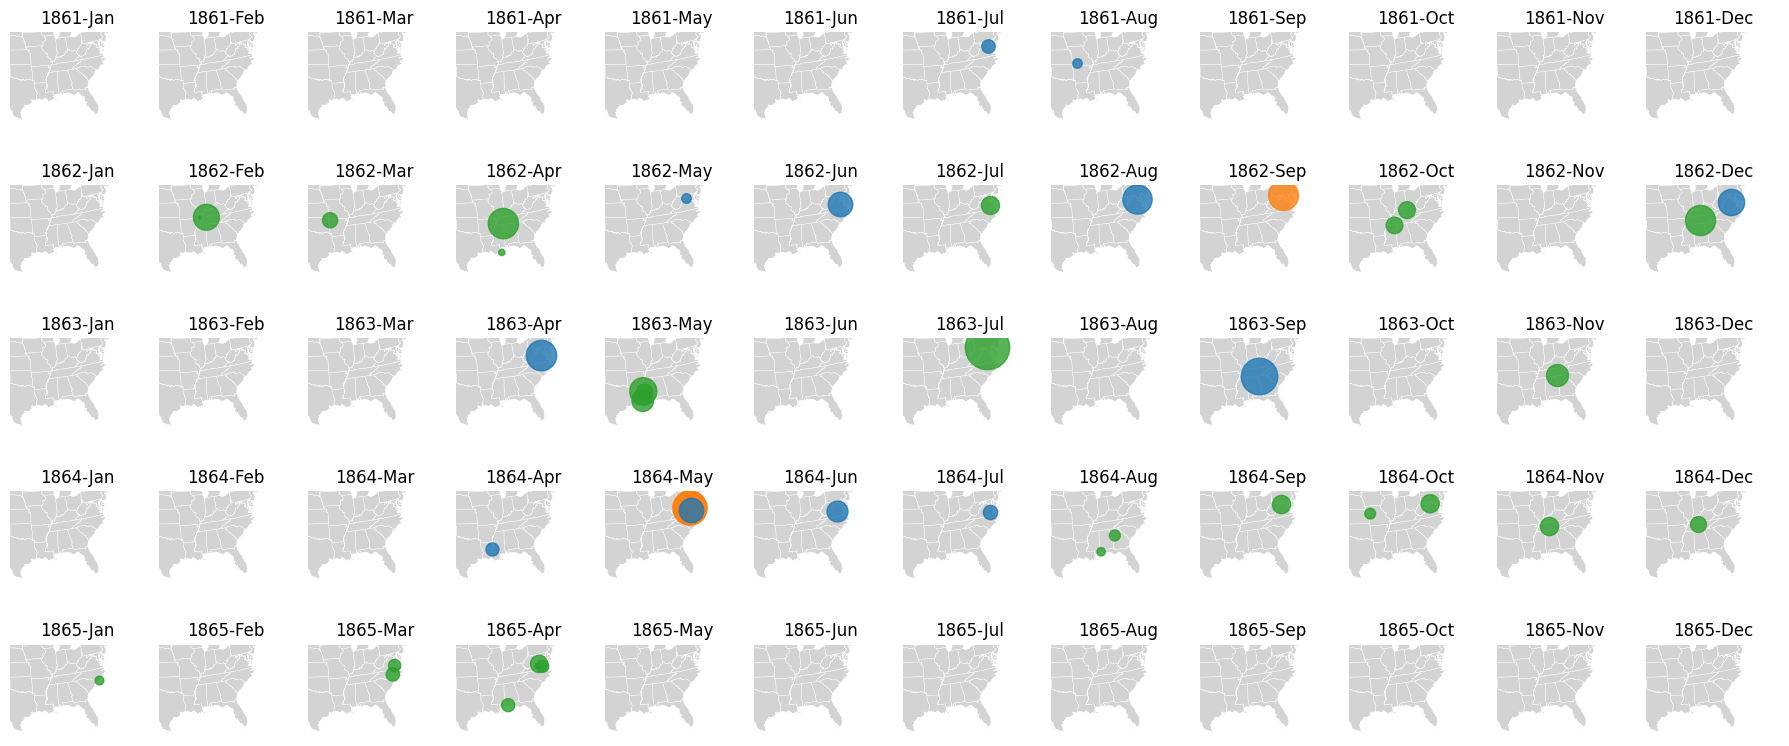

In [ ]:
f, maps = civil_war_basemap(nrows=5, ncols=12, figsize=(18, 8))

# Predefine an iterable of dates. The war begins in April 1861, and
# the Confederate government dissolves in spring of 1865.
dates = itertools.product(range(1861, 1865 + 1), range(1, 12 + 1))

for (year, month), m in zip(dates, maps):
    battles = df.loc[(df['start_date'].dt.year == year) &
                     (df['start_date'].dt.month == month) &
                     (df['significance'] == 'A')]
    lat, lon = battles['lat'].values, battles['lon'].values
    casualties, results = battles['casualties'], battles['result']
    plot_battles(lat, lon, casualties, results, m=(f, m))
    month_abbrev = calendar.month_abbr[month]
    m.set_title(f'{year}-{month_abbrev}')

plt.tight_layout();

The most important battles seem to have happened in summer & fall. Also, more important battles seem to have a larger number of casualties.

# Medium

In [ ]:
def denmark_basemap(nrows=1, ncols=1, figsize=(8, 8)):
    projection = ccrs.LambertConformal(central_latitude=50, central_longitude=10)
    extent = 8.09, 14.15, 54.56, 57.75
    return basemap('denmark.shp', projection, extent=extent,
                   nrows=nrows, ncols=ncols, figsize=figsize)

Text(0.5, 1.0, "Kristensen's Travels Through Denmark")

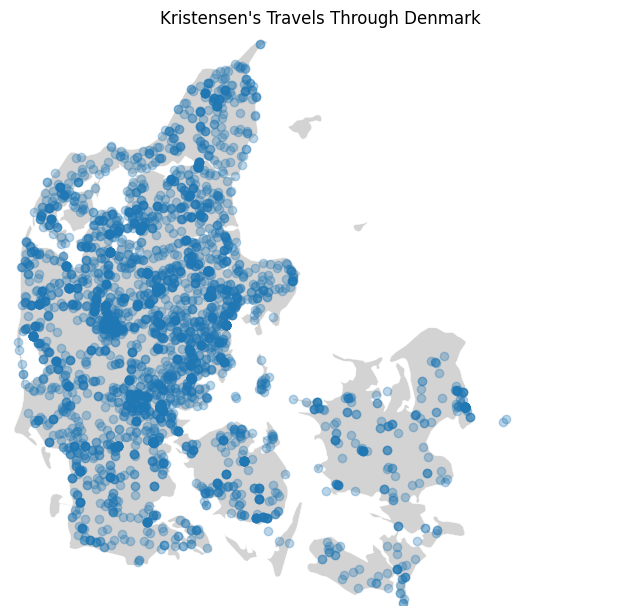

In [ ]:
dk = pd.read_csv('kristensen.csv')

# draw the map
fig, m = denmark_basemap(figsize=(8, 8))

# add points
m.scatter(dk['lon'], dk['lat'],
          zorder=2, marker='o', alpha=0.3, transform=ccrs.PlateCarree())
plt.title("Kristensen's Travels Through Denmark")

In [ ]:
def trip_color(result_type):
    """Helper function: return a qualitative color for each
       field trip
    """
    result_types = 10, 50, 100
    # qualitative color map, suited for categorical data
    color_map = matplotlib.cm.tab10
    return color_map(result_types.index(result_type))

Text(0.5, 1.0, "Kristensen's Travels on Selected Field Trips")

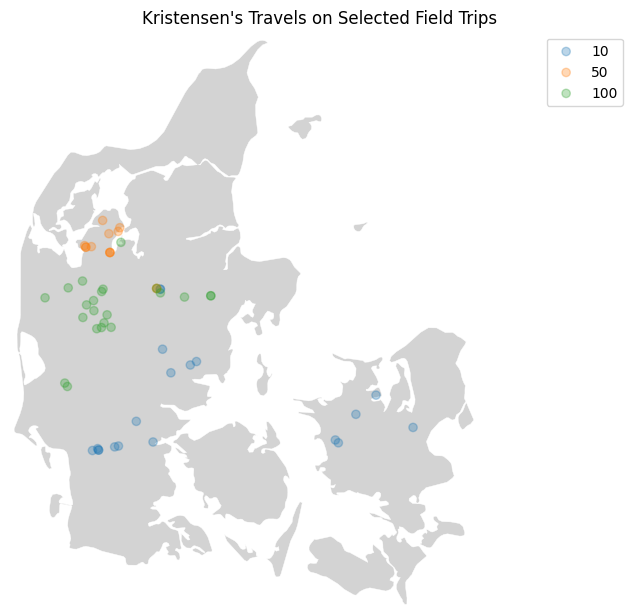

In [ ]:
trips_of_interest = [10, 50, 100]

trips = dk[dk['FT'].isin(trips_of_interest)]

fig, m = denmark_basemap(figsize=(8, 8))

for i, dff in trips.groupby('FT'):
  m.scatter(dff['lon'], dff['lat'],
    zorder=2, marker='o', alpha=0.3, c=dff['FT'].apply(trip_color),
    transform=ccrs.PlateCarree(), label=int(i))

m.legend()
plt.title("Kristensen's Travels on Selected Field Trips")


<Axes: title={'center': 'Number of Kristensen Visits by year'}, xlabel='Year', ylabel='# visits'>

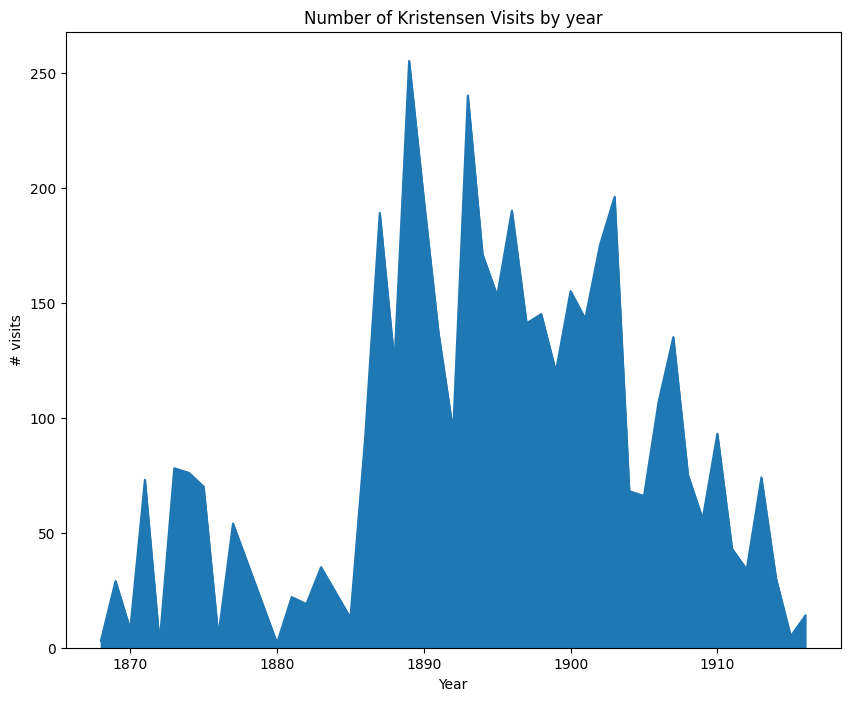

In [ ]:
dk.groupby(dk['Year']).size().plot(kind='area', figsize=(10,8), title='Number of Kristensen Visits by year', ylabel='# visits')

Kristensen was most active from 1887-1907.

Prior to 1887, he may have been starting his career, doing some initial trips and later spent time gathering funding to continue travelling or writing down what he learned (reflected in a drop in productivity during the 1880's).

The drop in productivity after that could be attributed to old age and less willingness/ability to travel, or more time spent compiling existing stories that have been collected.

# Challenging

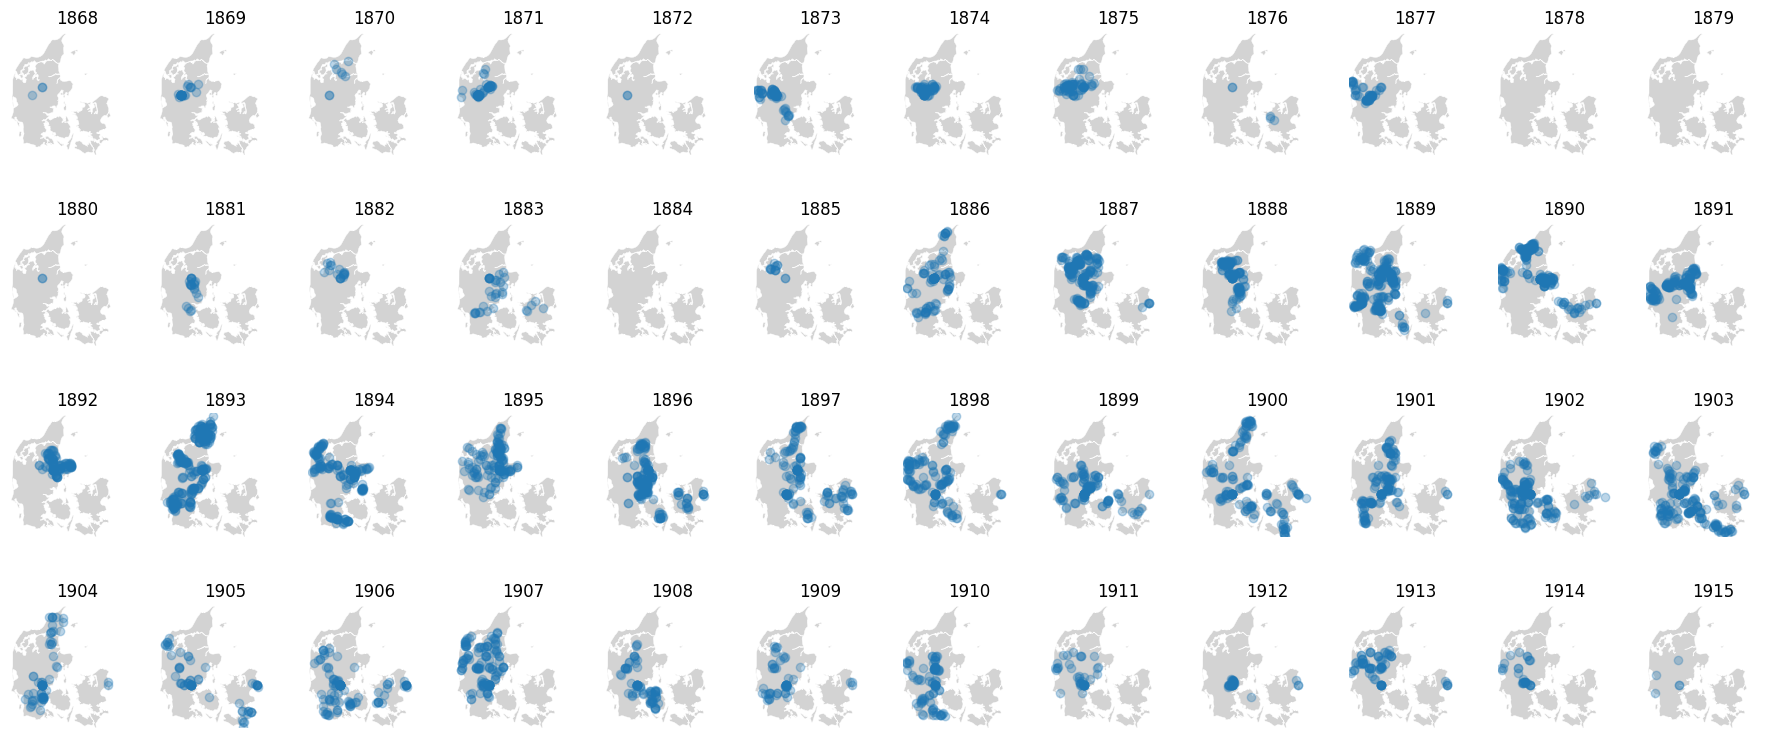

In [ ]:
# where did he travel every year?
f, maps = denmark_basemap(nrows=4, ncols=12, figsize=(18, 8))

years = range(dk['Year'].min(), dk['Year'].max()) # represent years in the range even when there were no trips

for year, m in zip(years, maps):
    visits = dk.loc[(dk['Year'] == year)]
    lat, lon = visits['lat'].values, visits['lon'].values
    m.scatter(lon, lat, zorder=2, marker='o', alpha=0.3, transform=ccrs.PlateCarree())
    m.set_title(f'{year}')

plt.tight_layout();

Text(0, 0.5, 'Distance (degrees lat/lon)')

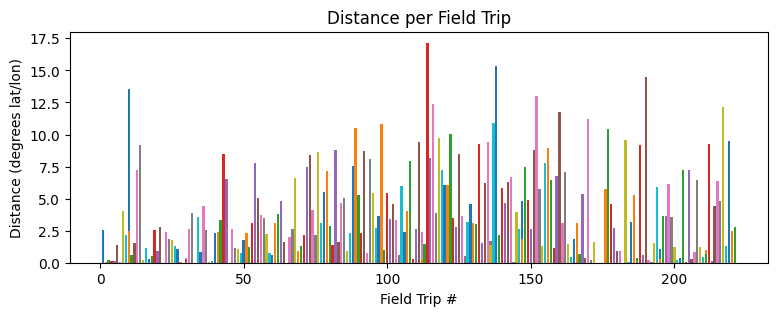

In [198]:
# how far did he travel on each field trip?
import numpy as np

def euclidean_distance(x1, y1, x2, y2):
  return np.sqrt((x2-x1)**2 + (y2-y1)**2)

plt.figure(figsize=(9,3))

for i, dff in dk.groupby('FT'):
  dff.sort_values(by=['Sequence']) # ensure in order
  dff['dist'] = euclidean_distance(dff.lon, dff.lat, dff.lon.shift(1), dff.lat.shift(1))

  dist_trip = dff['dist'].sum()
  plt.bar(int(i), dist_trip)


plt.title("Distance per Field Trip")
plt.xlabel("Field Trip #")
plt.ylabel("Distance (degrees lat/lon)")

Text(0.5, 1.0, 'Path of FT190 through Denmark')

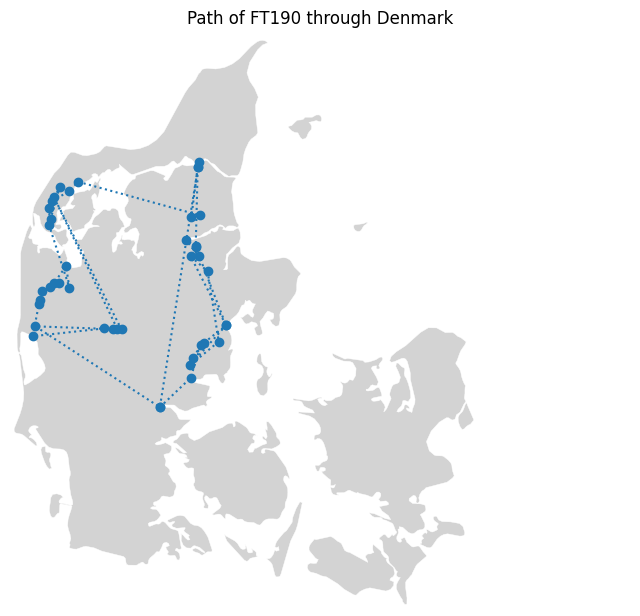

In [216]:
ft_190 = dk[dk['FT'] == 190]
fig, m = denmark_basemap(figsize=(8, 8))

# draw the map
m.plot(ft_190['lon'], ft_190['lat'], marker='o', linestyle=':', zorder=2, transform=ccrs.PlateCarree())
plt.title('Path of FT190 through Denmark')